<a href="https://colab.research.google.com/github/kaden-weber/Deep-Learning-Final-Project-Population-Projection/blob/estimate-population-only/FinalCensusData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# lab 10 imports 
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


In [0]:
# style 
### Used to style Python print statements, 
    # from https://stackoverflow.com/users/1770999/boubakr via Patrick Stetz
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [0]:
# my imports
import pandas as pd
import torch.nn.functional as F
import random


In [4]:
# auth with kaggle
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Dec 18 03:16 kaggle.json


In [5]:
#download dataset
!kaggle datasets download -d muonneutrino/us-census-demographic-data

 47% 5.00M/10.6M [00:00<00:00, 30.5MB/s]
100% 10.6M/10.6M [00:00<00:00, 52.0MB/s]


In [6]:
# unzip and import with pandas

def extract_zip(zip_file, extract_dir):
  print("Extracting", zip_file)
  print("To", extract_dir)
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

def read(csv_path):
  return pd.read_csv(csv_path, encoding='latin-1')

def unzip_once():
  zip_file='/content/us-census-demographic-data.zip'
  extract_dir = os.path.splitext(zip_file)[0]
  if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
  extract_zip(zip_file, extract_dir)

unzip_once() 
county_2015 = read(
    '../content/us-census-demographic-data/acs2015_county_data.csv')
tract_2015 = read(
    '../content/us-census-demographic-data/acs2015_census_tract_data.csv')
county_2017 = read(
    '../content/us-census-demographic-data/acs2017_county_data.csv')
tract_2017 = read(
    '../content/us-census-demographic-data/acs2017_census_tract_data.csv')
data_2015 = (county_2015, tract_2015)
data_2017 = (county_2017, tract_2017)
data_all = (county_2015, tract_2015, county_2017, tract_2017)

Extracting /content/us-census-demographic-data.zip
To /content/us-census-demographic-data


In [0]:
tract_2015 = tract_2015.drop(tract_2015[tract_2015.TotalPop == 0].index)
tract_2015 = tract_2015.drop(['State', 'County'], axis=1)

tract_2017 = tract_2017.drop(tract_2017[tract_2017.TotalPop == 0].index)
tract_2017 = tract_2017.drop(['State', 'County'], axis=1)

tract_2015 = tract_2015.dropna()
tract_2017 = tract_2017.dropna()

In [8]:
#dataset

class USCensusTractDataset(Dataset):
  def __init__(self, start_tracts, end_tracts, upload=False):
    super(USCensusTractDataset, self).__init__()
    self.start_tracts = start_tracts
    self.end_tracts = end_tracts

    self.start_t = torch.from_numpy(start_tracts.values.astype(np.float32))
    self.end_t = torch.from_numpy(end_tracts.values.astype(np.float32))
    self.dataset = self.couple(self.start_t, self.end_t)

    # do any data prep here

  def couple(self, start_t, end_t):
    coupledDataset = []
    for i in range(len(start_t)):
      row = start_t[i]
      start = i - 20
      if start < 0:
        start = 0
      stop = i + 20
      if stop >= len(end_t):
        stop = len(end_t - 1)
      match = self.findRowByID(end_t, start, stop, row[0])
      if match is not None:
        coupledDataset.append((row, match[1]))
    return coupledDataset

  
  def findRowByID(self, tensor, start, stop, id):
    # id is first entry in row
    for i in range(start, stop):
      if tensor[i, 0] == id:
        return tensor[i]
    return None

  def __getitem__(self, i):
    return self.dataset[i]

  def __len__(self):
    return len(self.dataset)

#example dataset that imports pandas dataframe
class EventsDataset(Dataset):
    def __init__(self, root_folder, data_set_name, numrows = None, mns_file_name = None ):
        self.my_file_name = os.path.join( root_folder, data_set_name )
        file_data = pd.read_csv(self.my_file_name, nrows = numrows )
        self.tensor_data = torch.from_numpy( file_data.values.astype(np.float32)  )
        del file_data

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        truth_data = self.tensor_data[idx, 1:3]
        recon_data = self.tensor_data[idx, 4:]
        return recon_data, truth_data


dataset = USCensusTractDataset(tract_2015, tract_2017)
item = dataset.__getitem__(0)
print(dataset.__len__())
print(item[0])
print(item[1])



72721
tensor([1.0010e+09, 1.9480e+03, 9.4000e+02, 1.0080e+03, 9.0000e-01, 8.7400e+01,
        7.7000e+00, 3.0000e-01, 6.0000e-01, 0.0000e+00, 1.5030e+03, 6.1838e+04,
        1.1900e+04, 2.5713e+04, 4.5480e+03, 8.1000e+00, 8.4000e+00, 3.4700e+01,
        1.7000e+01, 2.1300e+01, 1.1900e+01, 1.5200e+01, 9.0200e+01, 4.8000e+00,
        0.0000e+00, 5.0000e-01, 2.3000e+00, 2.1000e+00, 2.5000e+01, 9.4300e+02,
        7.7100e+01, 1.8300e+01, 4.6000e+00, 0.0000e+00, 5.4000e+00])
tensor(1845.)


In [0]:
# double check tract numbers 
# for i in range(dataset.__len__()):
#   x, y_index, y_truth = dataset.__getitem__(i)
#   if x[0] != y_index:
#     raise Exception('you messed up the indices')
  

In [0]:
#network(s)

#mnist example (from similar csv)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

class MyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(35, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# class MyClassifier(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = nn.Linear(35, 16)
#     self.fc2 = nn.Linear(16, 8)
#     self.fc3 = nn.Linear(8, 4)
#     self.fc4 = nn.Linear(4, 1)
#     self.dropout = nn.Dropout(p=0.2)
      
#   def forward(self, x):
#       # x = x.view(x.shape[0], -1)
#       x = F.relu(self.fc1(x))
#       x = F.relu(self.fc2(x))
#       x = self.dropout(F.relu(self.fc3(x)))
#       x = self.fc4(x)
      
#       return x

In [0]:
batch_size = 512

# instantiate dataset
train_dataset = USCensusTractDataset(tract_2015, tract_2017)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)


In [0]:
# training

epochs = 100
learning_rate = 0.1
val_every = 3
device = torch.device('cuda:0')

# model
model = MyClassifier().to(device)

# objective = nn.CrossEntropyLoss()
objective = nn.L1Loss()
# objective = nn.NLLLoss()
# objective = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accs = []

In [30]:
# Training Loop
pbar = tqdm(total=len(train_loader) * epochs)

count = 0 
for epoch in range(epochs):
  for x, y_truth in train_loader:
    x, y_truth = x.to(device), y_truth.to(device)

    optimizer.zero_grad()

    y_hat = model(x).squeeze(-1)
    # print(x.size())
    # print(y_hat.size())
    # print(y_truth.size())
    train_loss = objective(y_hat, y_truth)

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
      
    pbar.set_description('train loss:{0:16.4f}'.format(train_loss.item()))
    pbar.update(1)

    count += 1

pbar.close()

train loss:       1489.6781: 100%|██████████| 14300/14300 [01:37<00:00, 136.30it/s]


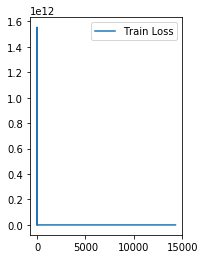

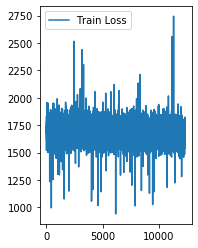

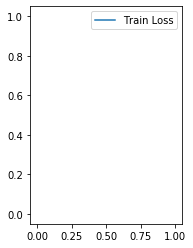

beginning loss 1699.919620361328
ending loss 1657.128916015625


In [31]:
plt.subplot(122)
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.legend()
plt.show()

zoom = train_losses[2000:]
plt.subplot(122)
plt.plot(np.arange(len(zoom)), zoom, label='Train Loss')
plt.legend()
plt.show()

zoom2 = train_losses[15000:]
plt.subplot(122)
plt.plot(np.arange(len(zoom2)), zoom2, label='Train Loss')
plt.legend()
plt.show()

print("beginning loss", np.mean(train_losses[200:400]))
print("ending loss", np.mean(train_losses[-200:]))

In [14]:
# validate
diffs = []

for i in range(50):
  tract_index = random.randint(0, train_dataset.__len__())
  x, goal = train_dataset.__getitem__(tract_index)
  output = model(x.to(device))

  initial_pop = int(x[1])
  final_pop = int(goal.item())
  est_pop = int(output.item())

  actual_population_change = final_pop - initial_pop
  predicted_population_change = est_pop - initial_pop

  diffs.append( abs( (actual_population_change - predicted_population_change) / actual_population_change * 100) )
  if i % 10 == 0:
    print('\nTract:', int(x[0]))
    print('beginning =', initial_pop)
    print('end       =', final_pop)
    print('actual population change     =', actual_population_change)
    print('predicted population change  =', predicted_population_change)

print('average % error =', np.mean(diffs))



Tract: 13089022976
beginning = 4599
end       = 6512
actual population change     = 1913
predicted population change  = -520

Tract: 8123000832
beginning = 4889
end       = 2147
actual population change     = -2742
predicted population change  = -791

Tract: 6111001600
beginning = 5206
end       = 4109
actual population change     = -1097
predicted population change  = -1100

Tract: 6037621248
beginning = 6595
end       = 4533
actual population change     = -2062
predicted population change  = -2506

Tract: 24015030272
beginning = 5454
end       = 4738
actual population change     = -716
predicted population change  = -1019
average % error = 329.03805263660996


In [0]:
# best loss so far =~ 1604